# NLP final project
 Ram Elias     id:205445794

 Eliezer Seror id:312564776
 
 Yael Seror    id:318345162

## Data-driven Analysis of Hotel Reviews: Sentiment and Topic Modeling

This project involves using data mining techniques to analyze hotel reviews and identify factors that influence guest satisfaction.

First, the code uses web scraping and BeautifulSoup to extract hotel review data from Booking.com. The user can specify which hotel to scrape and how many pages of reviews to extract.

Next, exploratory data analysis (EDA) techniques are used to understand the data and visualize the distribution of ratings, the most common positive and negative words, and other important metrics.

Then, a sentiment analysis is performed to classify each review as either positive, negative, or neutral. This is done using the TextBlob library, which uses natural language processing (NLP) to analyze text.

The code also uses tf-idf (term frequency–inverse document frequency) to identify the most important words and phrases in the reviews. This helps to identify common themes and topics that guests are mentioning in their reviews.

Finally, Latent Dirichlet Allocation (LDA) topic modeling is used to cluster the reviews into different topics. This technique helps to identify common themes and topics that guests are discussing in their reviews.

Overall, this code provides a comprehensive analysis of hotel reviews, allowing hotel managers to identify areas for improvement and address guest concerns.

#Part I: Excracting Hotel Reviews from Booking.com

The first step in analyzing the reviews of Hotel Beresford in San Francisco, CA is to scrape the data from booking.com. The data we need to extract includes:

Rating score
Reviewer name
Reviewer nationality
Overall review (containing both positive and negative feedback)
Number of times the reviewer has posted reviews
Review date
Review tags (such as business trip, leisure trip, etc.)
Positive reviews
Negative reviews
To extract this information, we will use the following inputs:

Hotel name in the booking.com web link
Total number of pages of reviews to scrape
The output will consist of the following dataframes:

Reviewer_info: includes reviewers' basic information
Pos_reviews: includes all the positive reviews
Neg_reviews: includes all the negative reviews
With these dataframes, we will be able to analyze the sentiment of the reviews and identify any recurring issues or areas of praise for the hotel.

In [23]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import re

hotel_name = 'grange-st-paul-s' #The hotel we chose to check, can be change for Any different UK hotel
max_pages = 8 # max of review page we excract
info = []
positive = []
negative = []

#bookings.com reviews link         
url_template = f'https://www.booking.com/reviews/gb/hotel/{hotel_name}.en-gb.html'

#loop to get all the review pages
for page_number in range(1,max_pages+1):
    #define the current url by the page
    url = url_template + '?page=' + str(page_number)

    #get the data
    page = requests.get(url)

    #get the object using the html source and Python’s html.parser
    b_soup = bs(page.text, "html.parser") 
    #save the relevent ocject (the review) from the html page
    review_box = b_soup.find('ul',{'class':'review_list'})
    if review_box is None:
        break

    #ratings
    ratings = [i.text.strip() for i in review_box.find_all('span', {'class': 'review-score-badge'})]

    #reviewer_info
    reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
    reviewer_name, reviewer_country, general_review = reviewer_info[0::3], reviewer_info[1::3], reviewer_info[2::3]

    # reviewer_review_times
    review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

    # review_date
    review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

    #reviewer_tag
    reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i in review_box.find_all('ul',{'class':'review_item_info_tags'})]

    # positive_review
    positive_review = [i.text.strip().strip() for i in review_box.find_all('p',{'class':'review_pos'})]

    # negative_review
    negative_review = [i.text.strip().strip() for i in review_box.find_all('p',{'class':'review_neg'})]
    # append all reviewers' info into one list
    for i in range(len(reviewer_name)):
        info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i],review_times[i],review_date[i]])
    
    # build positive review list
    for i in range(len(positive_review)):
        positive.append(positive_review[i])

    # build negative review list
    for i in range(len(negative_review)):
        negative.append(negative_review[i])


#Reviewer_info df
reviewer_info = pd.DataFrame(info, columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date'])
reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])

#make positive & negative reviews to dfs
pos_reviews = pd.DataFrame(positive, columns = ['positive_reviews'])
neg_reviews = pd.DataFrame(negative, columns = ['negative_reviews'])


In [24]:
def show_data(df,title):
    print(f"\033[1m\033[96mThe length of {title} dataframe is: {len(df)}\033[0m")
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', None)  # Widen the display area
    display(df.head())


#reviewers' basic information
show_data(reviewer_info, 'info')
#positive reviews
show_data(pos_reviews, 'positive')
# positive review
show_data(neg_reviews, 'negative')



The length of info dataframe is: 199


,Rating,Name,Country,Overall_review,Review_times,Review_date
0,9.0,Chloe,United Kingdom,Really lovely hotel.,1,2023-03-11
1,9.0,Luke,United Kingdom,"Lovely weekend, staff accommodated my valentin...",1,2023-03-11
2,7.0,Victoria,United Kingdom,Good,24,2023-03-10
3,9.0,Anna,United Kingdom,Loved it,14,2023-03-09
4,8.0,Greg,United Kingdom,lovely hotel. great location,6,2023-03-08


The length of positive dataframe is: 198


,positive_reviews
0,"The Bedroom was large, the main areas were cle..."
1,Spa was lovely room was perfect
2,"location,\nspa and gym"
3,"The people, customer service, spa facilities, ..."
4,location. room nice. breakfast good


The length of negative dataframe is: 163


,negative_reviews
0,The bathroom bin and room bin weren't emptied ...
1,"Room had no view, nothing can really help that..."
2,rooms very tight and small for the price
3,N/A
4,my only issue was even tho id asked for a cot ...


## Part II.  Exploratory Data Analysis

### 1. Positive to negative review ratio.

This code creates a bar chart showing the ratio of positive and negative reviews in a dataset, with labels showing the percentage and count of each category. It uses matplotlib to generate the visualization.
 

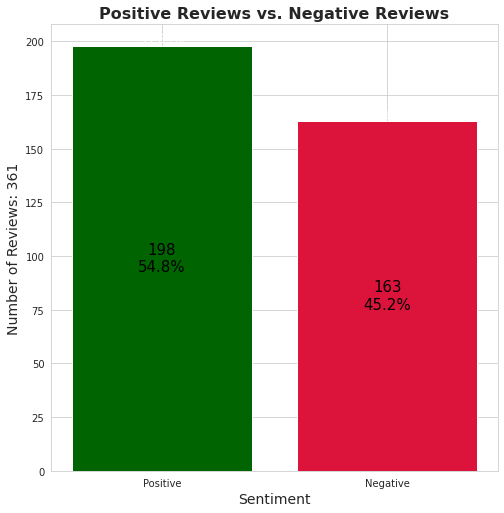

In [25]:
import matplotlib.pyplot as plt

# Get the total number of reviews
num_reviews = len(pos_reviews) + len(neg_reviews)

# Calculate the percentages of positive and negative reviews
percent_pos = len(pos_reviews) / num_reviews * 100
percent_neg = len(neg_reviews) / num_reviews * 100

# Create a bar chart to compare the two categories
fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(['Positive', 'Negative'], [len(pos_reviews), len(neg_reviews)], color=['#006400', '#DC143C'])
ax.set_xlabel('Sentiment', fontsize=14)
ax.set_ylabel(f'Number of Reviews: {num_reviews}', fontsize=14)
ax.set_title('Positive Reviews vs. Negative Reviews', fontsize=16, fontweight='bold', fontfamily='Arial')

# Add labels to the top of each bar showing the percentage of reviews in each category
ax.text(0, len(pos_reviews), f'{percent_pos:.2f}%', ha='center', va='bottom', color='white', fontsize=12)
ax.text(1, len(neg_reviews), f'{percent_neg:.2f}%', ha='center', va='bottom', color='white', fontsize=12)

# Add percentage values and count inside each bar
for i, v in enumerate([len(pos_reviews), len(neg_reviews)]):
    ax.text(i, v / 2, f'{v}\n{v / num_reviews * 100:.1f}%', ha='center', va='center', color='black', fontsize=15)

# Add more whitespace around the plot
fig.subplots_adjust(top=0.9, right=0.9)

plt.show()



### 2. Rating score histogram
This code creates a histogram of ratings data, sets labels and x-ticks, and adds counts to each bar for visualization.

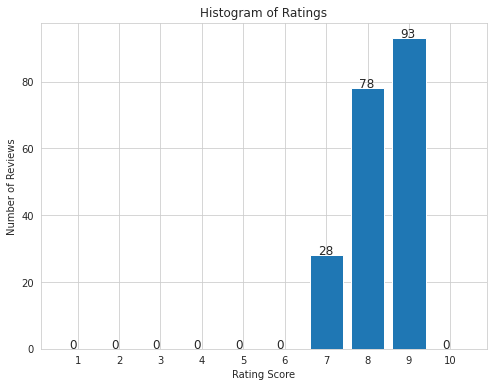

In [26]:

fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram
n, bins, patches = plt.hist(reviewer_info['Rating'], bins=range(1, 12), align='left', rwidth=0.8)

# Set x-ticks
plt.xticks(range(1, 11))

# Set labels and title
plt.xlabel('Rating Score')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Ratings')

# Add count to each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x()+0.2, patches[i].get_height()+0.2, int(n[i]), fontsize=12)

plt.show()



# 3. Top ratings conutry region 

In [27]:
top = reviewer_info.groupby('Country').size().reset_index().sort_values('Country', ascending=True).head(reviewer_info.Country.nunique())
top.columns = ['Country', 'Counts']
top.index = top.index + 1 # add 1 to the index
print(f"\033[1m\033[96mTop {reviewer_info.Country.nunique()} countries ranked by review counts\033[0m")
display(top)

Top 21 countries ranked by review counts


,Country,Counts
1,Australia,2
2,Belgium,5
3,France,2
4,Guernsey,1
5,Hungary,1
6,Ireland,7
7,Israel,2
8,Lithuania,1
9,Luxembourg,2
10,Netherlands,6


## Part III.  Text Analytics

### 1. Lemmatize Tokens



The code defines a function to lemmatize text, removing stop words and punctuation, and normalizing words using their POS tags. It also downloads necessary NLTK resources.

In [28]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string


nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define a dictionary to map POS tags to WordNet tags
pos_to_wordnet = {"J": wordnet.ADJ,
                  "V": wordnet.VERB,
                  "N": wordnet.NOUN,
                  "R": wordnet.ADV}

def get_wordnet_pos(pos_tag):
    return pos_to_wordnet.get(pos_tag[0], wordnet.NOUN)

def lemmatized_tokens(text):
    # Convert text to lowercase
    text = text.lower()

    # Define a regex pattern to match words with at least 3 alphabetical characters
    pattern = r'\b[a-zA-Z]{3,}\b'

    # Tokenize the text
    tokens = nltk.regexp_tokenize(text, pattern)

    # Tag the tokens with POS tags
    tagged_tokens = nltk.pos_tag(tokens)

    # Define stop words to be removed
    stop_words = set(stopwords.words('english'))
    new_stopwords = {"hotel", "everything", "anything", "nothing", "thing", "need",
                     "good", "great", "excellent", "perfect", "much", "even", "really"}
    stop_words.update(new_stopwords)

    # Initialize a WordNet lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

    # Lemmatize the tokens, remove stop words and punctuations
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                        for word, tag in tagged_tokens
                        if word.lower() not in stop_words and word.isalpha()]

    return lemmatized_words



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 2. Generate WordClouds

The word clouds display the most frequent words in the reviews using a color scheme that contrasts with the background color. The size of the word corresponds to its frequency of appearance in the reviews. The title of each word cloud indicates whether it represents positive or negative reviews.

In [29]:
from wordcloud import WordCloud

#Create a function to generate wordcloud
def wordcloud(review_df, review_colname, color, title):
    '''    
    INPUTS:
        reivew_df - dataframe, positive or negative reviews
        review_colname - column name, positive or negative review
        color - background color of worldcloud
        title - title of the wordcloud
    OUTPUT:
    Wordcloud visuazliation
    '''  
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=1,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    
    return plt.show()   



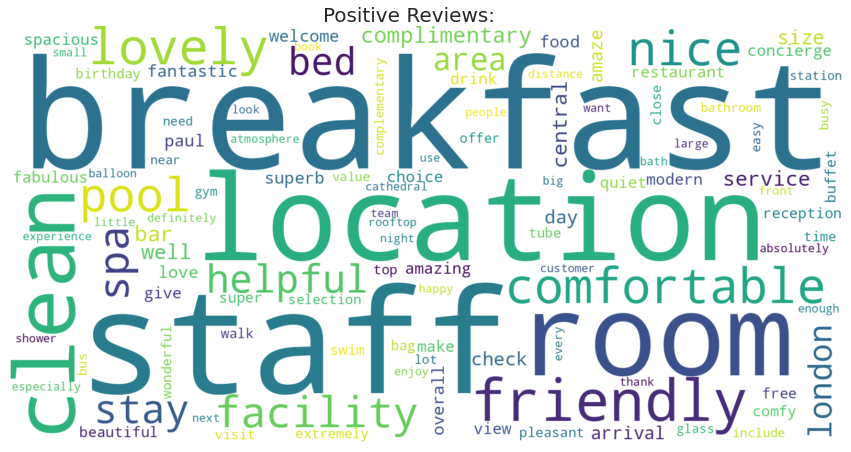

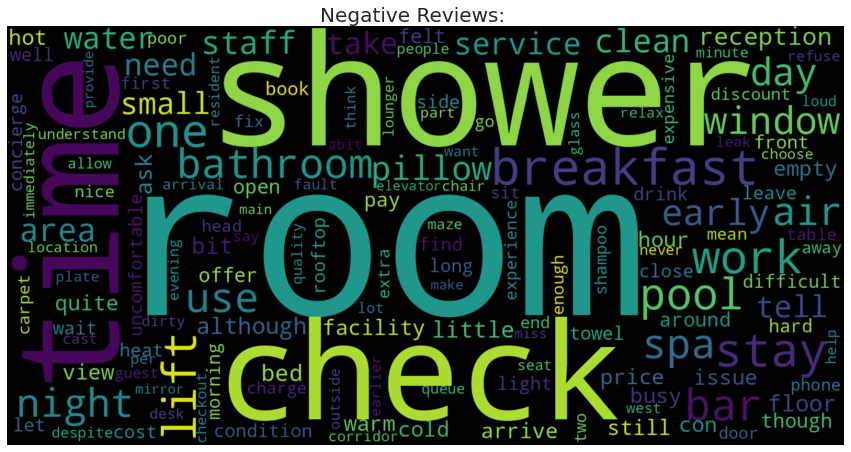

In [19]:

# Wordcoulds for Positive Reviews
wordcloud(pos_reviews,'positive_reviews', 'white','Positive Reviews: ')

# # WordCoulds for Negative Reviews
wordcloud(neg_reviews,'negative_reviews', 'black', 'Negative Reviews:')

### 3. Sentiment Analysis

The x-axis shows the sentiment score ranging from 0 (negative) to 1 (positive), and the y-axis shows the count of reviews falling into each sentiment score bin. 
The plot helps to visualize the overall sentiment of the reviews and how many of them are positive or negative.*bold text*

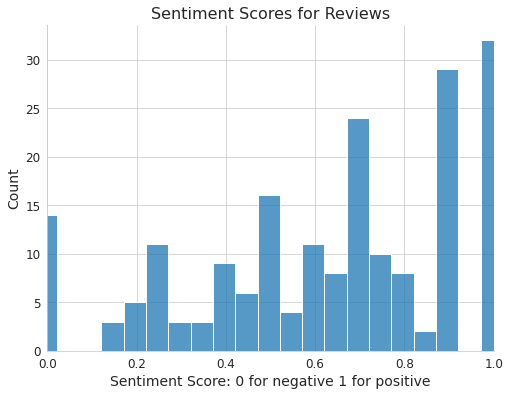

In [20]:
from textblob import TextBlob
import seaborn as sns

# Compute the sentiment scores for each review
sentiment_scores = [TextBlob(review).sentiment.polarity for review in reviewer_info['Overall_review']]
reviewer_info['Sentiment_score'] = sentiment_scores

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the sentiment scores using a histogram
sns.histplot(data=reviewer_info, x="Sentiment_score", binwidth=0.05, ax=ax)
ax.set_title('Sentiment Scores for Reviews', fontsize=16)
ax.set_xlabel('Sentiment Score: 0 for negative 1 for positive', fontsize=14)
ax.set_xlim(0, 1)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
sns.despine()

plt.show()



### 4. The base for the insights 

By using the LDA model, we can start to create the foundation we need to generate valuable insights.

LDA is a model that helps us understand the underlying topics in a set of documents. In our case, we can apply the LDA model to find the topic distribution of each document and identify the high probability of words in each topic.

Using LDA, we can identify the aspects that the hotel should prioritize for improvement. This way, we can gather insights that will help the hotel make meaningful changes to enhance the overall guest experience.

To find the best LDA model, we start by creating a document-term matrix from the reviews. This involves using a combination of term frequency (TF) and inverse document frequency (IDF) to determine how important each word is in the text. We filter out words that appear in over 90% of the reviews, as well as those that appear in fewer than 10 reviews, to focus on meaningful and relevant words.

We grid search to find the optimal LDA model by tuning two parameters: n_components and learning_decay. We output the optimal lda model and its parameters and diagnose the model performance with perplexity and log-likelihood scores. Finally, we compare LDA model performance scores using a line plot.

The shape of the tfidf is (163, 14), meaning that there are 163 negative_reviews and 14 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Model Log Likelihood Score:  -146.76843425110656
Model Perplexity:  28.364226115433105


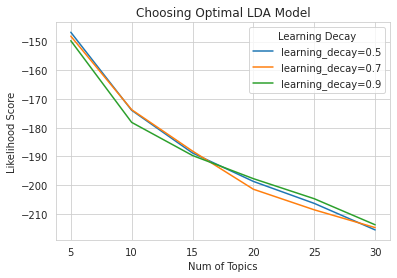

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


def optimal_lda_model(df, col_name, n_topics_range=[5, 10, 15, 20, 25, 30], 
                      learning_decay_range=[0.5, 0.7, 0.9], max_df=0.9, min_df=10):
    '''
    INPUTS:
        df - dataframe that contains the reviews
        col_name: name of column that contains reviews
        n_topics_range: a list of integers indicating the range of the number of topics to be tested
        learning_decay_range: a list of floats indicating the range of learning decay rates to be tested
        max_df: a float indicating the maximum document frequency threshold for CountVectorizer
        min_df: an integer indicating the minimum document frequency threshold for CountVectorizer

    OUTPUTS:
        lda_model - the optimal LDA model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    docs_raw = df[col_name].tolist()

    # vectorize the corpus using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', lowercase=True, 
                                       token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=max_df, min_df=min_df)
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
          format(dtm_tfidf.shape, dtm_tfidf.shape[0], col_name, dtm_tfidf.shape[1]))

    # perform grid search to find the optimal LDA model
    search_params = {'n_components': n_topics_range, 'learning_decay': learning_decay_range}
    lda_model = LatentDirichletAllocation()
    model = GridSearchCV(lda_model, param_grid=search_params)
    model.fit(dtm_tfidf)

    # print the results
    print("Best Model's Params: ", model.best_params_)
    print("Model Log Likelihood Score: ", model.best_score_)
    print("Model Perplexity: ", model.best_estimator_.perplexity(dtm_tfidf))

    # plot the results
    n_topics = n_topics_range
    log_likelyhoods = []
    for learning_decay in learning_decay_range:
        log_likelyhoods.append([model.cv_results_['mean_test_score'][i] for i in 
                               range(len(model.cv_results_['params'])) if model.cv_results_['params'][i]['learning_decay'] == learning_decay])
    log_likelyhoods = np.array(log_likelyhoods)
    for i in range(len(learning_decay_range)):
        plt.plot(n_topics, log_likelyhoods[i], label="learning_decay={}".format(learning_decay_range[i]))
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num of Topics")
    plt.ylabel("Likelihood Score")
    plt.legend(title='Learning Decay', loc='best')
    plt.show()

    return model.best_estimator_, dtm_tfidf, tfidf_vectorizer

best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(neg_reviews, 'negative_reviews')

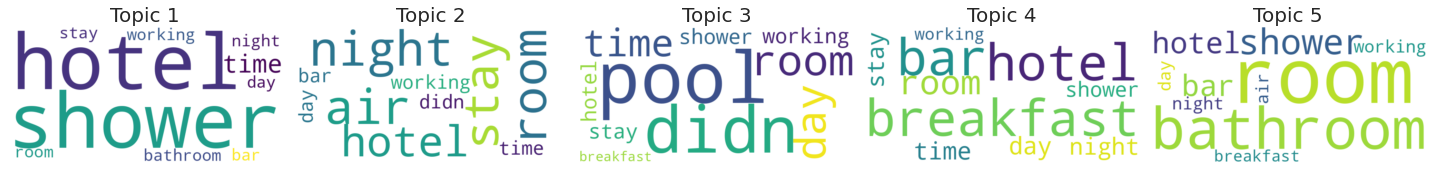

,Topic,Top Words,Weights
0,Topic 1,"[hotel, shower, time, working, night, day, roo...","[16.299, 15.301, 11.712, 7.761, 4.312, 3.737, ..."
1,Topic 2,"[air, stay, night, room, hotel, working, didn,...","[8.469, 5.597, 1.874, 0.204, 0.204, 0.202, 0.2..."
2,Topic 3,"[pool, didn, room, day, time, working, shower,...","[12.304, 8.184, 4.268, 3.508, 0.203, 0.202, 0...."
3,Topic 4,"[breakfast, bar, hotel, room, day, time, night...","[13.618, 9.182, 0.203, 0.203, 0.203, 0.202, 0...."
4,Topic 5,"[room, bathroom, shower, hotel, bar, working, ...","[30.352, 9.425, 0.202, 0.202, 0.201, 0.201, 0...."


In [22]:
def wordcloud(model, feature_names):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matrix represents

    OUTPUTS:
        a wordcloud visualization of the most frequent words in each topic
    '''
    
    # Get the top words for each topic
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[f'Topic {idx+1}'] = [feature_names[i] for i in topic.argsort()[:-11:-1]]

    # Create the wordclouds
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    axes = axes.flatten()

    for i, topic in enumerate(topics):
        wc = WordCloud(background_color="white", max_words=50, width=800, height=400).generate(" ".join(topics[topic]))
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'{topic}', fontsize=20)
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

def display_topics(model, feature_names, n_top_words=10):
    """
    INPUTS:
        model - the trained LDA model
        feature_names - list of feature names from the vectorizer
        n_top_words - number of top words to display for each topic
    
    OUTPUTS:
        topics_df - dataframe with the top words and their weights for each topic
    """
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        # Get the top n words and their weights for the current topic
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        weights = [round(topic[i], 3) for i in topic.argsort()[:-n_top_words-1:-1]]
        topic_data = list(zip(top_words, weights))
        
        # Add the topic data to the list of topics
        topics.append({
            "Topic": f"Topic {topic_idx+1}",
            "Top Words": [x[0] for x in topic_data],
            "Weights": [x[1] for x in topic_data]
        })
    
    # Create a dataframe from the topics list and return it
    topics_df = pd.DataFrame(topics)
    return topics_df

# Visualize the topics in a word cloud
wordcloud(best_lda_model, tfidf_vectorizer.get_feature_names_out())
display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 20) 